In [1]:
#imports
import numpy as np
import astropy.units as u
import astropy.table as tbl
import matplotlib.pyplot as plt

from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G

In [429]:
class MassProfile:
# Class to define 

    def __init__(self, galaxy, snap):
        ''' Class to find the mass profile of a galaxy 
            
            parameters
            ----------
                galaxy: a string with galaxy name (ex MW, M31, M33)
                snap: Snapshot number
            
        '''
        # add a string of the filename to the value "000"
        ilbl = '000'+str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy)+ilbl+'.txt'
     
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # store the mass, positions, velocities 
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        self.vx = self.data['vx']*u.km/u.s
        self.vy = self.data['vy']*u.km/u.s
        self.vz = self.data['vz']*u.km/u.s
        
        #galaxy name as global property
        self.gname = galaxy

        
    def MassEnclosed(self, ptype, radii):
        '''
        This function computes the mass enclosed
        within a given radius of the COM position for a galaxy's component.

        Inputs:
            ptype:`int; 1, 2, or 3`
                particle type to use for COM calculations
            radii: 'array'
                array of radii in magnitude

        Outputs: 
            masses_enclosed: 'astropy quantity array'
                an array of the enclosed mass at each radius specified
                in M_sun units

        '''
        #creating centerOfMass objects and calling COM_P
        COM = CenterOfMass(self.filename, ptype)
        COM_p = COM.COM_P(0.1)
        print(COM_p)
        
        
        index = np.where(self.data['type'] == ptype)
        
        #loop over radius array to define particels that are enclosed 
        #within the radius given
        
        self.m_new = self.m[index]
        
        masses_enclosed = np.zeros(len(radii))
        for i in range(len(radii)):
            
            distance_magnitude = np.sqrt((self.x[index]-COM_p[0])**2 
                                         +(self.y[index]-COM_p[1])**2 
                                         +(self.z[index]-COM_p[2])**2)
            #print('radius',radii[i])
            #print('distmag',distance_magnitude)
            enclosed_index = np.where(distance_magnitude/u.kpc < radii[i])
            
            #print('dis mag',distance_magnitude)
            
            #store the sum of masses of the particles within the radius
            masses_enclosed[i]= sum(self.m_new[enclosed_index])
            
        return masses_enclosed * 1e10 *u.Msun
    
    
    def MassEnclosedTotal(self, radii):
        ''' Calculate total enclosed mass from each particle type
        
        Inputs:
            radii: 'array'
                an array of radii to calculate the enclosed mass at each point
        
        Outputs:
            total_mass: 'astropy quantity array'
                an array of the toal mass enclosed at each radii in M_sun
        
        '''
        
        # calulating the mass enclosed for each particle type
        halo_mass = self.MassEnclosed(1, radii)
        disk_mass = self.MassEnclosed(2, radii)
        if self.gname != 'M33': # M33 doesn't have a buldge mass, so we skip it
            bulge_mass = self.MassEnclosed(3, radii)  
            total_mass = halo_mass + disk_mass + bulge_mass
        else:
            total_mass = halo_mass + disk_mass
            
        return total_mass
    
    def HernquistMass(self, radii, a, Mhalo):
        '''
        Compute the mass enclosed within a given radius
        
        M=M_halo*r^2/(a+r)^2
        
        inputs:
            radius: 'array'
                an array of radii values
            a: 'float'
                hernquist scale factor
            Mhalo: 'array'
                the halo mass of the galaxy
            
        outputs:
            M: the mass enclosed at a given radius in M_sun
            
        '''
        
        # hernquist mass profile
        
        M = (Mhalo*radii**2/(a+radii)**2 )*u.Msun
            
        return M
        
        
    def CircularVelocity(self, ptype, radii, G):
        '''
        This function calculate circular speed at each radii.
        
        Inputs:
            ptype: 'float'
                particle type
            radii: 'array'
                and array of radii for the circular speed to be calculated at 
            G: 'astropy constant'
                gravitational constant in kms units
        
        Output:
            Vcirc:'astropy quantity array"
                an array of circular speeds in units of km/s, rounded to two decimal places.
        
        '''
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting units
        
        # finding enclosed mass
        M_enclosed = self.MassEnclosed(ptype, radii)
        
        # applying circular speed formula
        Vcirc = np.round(np.sqrt(G*M_enclosed/(radii*u.kpc)), 2)
        
        #print(Vcirc)
        
        return Vcirc
    
    def CircularVelocityTotal(self, radii, G):
        '''This function calculates the total circular velocity 
        representing the total Vcirc created by all the galaxy components
        at each radius of the input array.
        
        Inputs:
            radii:'array'
                an array of radii
            G: 'astropy constant'
                gravitational constant in kms units
        
        Outputs:
            total_Vcirc: 'astropy quantity array'
                an array of circular velocity (in units of km/s)
                
        '''
        
        # calculating the circular velocity for each particle type
        halo_Vcirc = self.CircularVelocity(1, radii, G)
        disk_Vcirc = self.CircularVelocity(2, radii, G)
        if self.gname != 'M33': # M33 doesn't have a buldge mass, so we skip it
            bulge_Vcirc = self.CircularVelocity(3, radii, G)  
            total_Vcirc = halo_Vcirc + disk_Vcirc + bulge_Vcirc
        else:
            total_Vcirc = halo_Vcirc + disk_Vcirc
            
        return total_Vcirc
    
    def HernquistVcirc(self,radius,a, Mhalo, G):
        '''
        This function computes the circular speed using the Hernquist mass profile
        
        Inputs:
            radius: 'array'
                and array of radii for the circular speed to be computed at
            a: 'float'
                Hernquist scale factor
            Mhalo: 'array'
                an array of the halo mass of the galaxy
            
        
        '''
        
        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting units
        
        Mass_Hern = self.HernquistMass(radius,a,Mhalo) # calculating the hernquist mass
        
        Vcirc = np.round(np.sqrt(G*Mass_Hern/(radius*u.kpc)), 2) #round and add units
        
        print(Vcirc)
        
        return Vcirc
    



## MW mass profile

In [474]:
MW = MassProfile("MW", 0) # initializing MW classs

In [475]:

r = np.arange(0.1, 30.5, 0.5) # radius range we are using up to 30kpc


# calculating enclosed mass for each galaxy component for each radius
enclosed_mass_MW_halo = MW.MassEnclosed(1,r)
enclosed_mass_MW_disk = MW.MassEnclosed(2,r)
enclosed_mass_MW_bulge = MW.MassEnclosed(3,r)

# calculating the total mass enclosed at each radius
total_mass_MW = MW.MassEnclosedTotal(r)


[-1.9   2.62 -1.6 ] kpc
[-2.07  2.95 -1.45] kpc
[-1.92  2.64 -1.32] kpc
[-1.9   2.62 -1.6 ] kpc
[-2.07  2.95 -1.45] kpc
[-1.92  2.64 -1.32] kpc


In [476]:
a = 40 # estimated scale factor
hernquist_profile = MW.HernquistMass(r, a, sum(MW.m_new*1e12)) # finding hernquist model halo mass enclosed

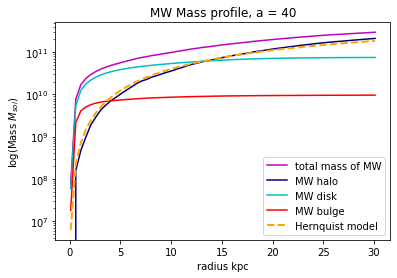

In [477]:
# plotting MW mass profile
plt.semilogy(r, total_mass_MW, label='total mass of MW', c='m')
plt.semilogy(r, enclosed_mass_MW_halo, label='MW halo', c='navy')
plt.semilogy(r, enclosed_mass_MW_disk, label='MW disk', c='c')
plt.semilogy(r, enclosed_mass_MW_bulge, label='MW bulge', c='red')
plt.semilogy(r,hernquist_profile, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('log(Mass $M_{sol}$)')
plt.xlabel('radius kpc')
plt.title("MW Mass profile, a = %s" % a)
plt.legend()

# MW velocity curve


In [478]:
G 

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [479]:
# calculating the circular velocity at each radius for each galaxy component
velocity_MW_halo = MW.CircularVelocity(1, r, G)
velocity_MW_disk = MW.CircularVelocity(2, r, G)
velocity_MW_bulge = MW.CircularVelocity(3, r, G)

# calculating the circular velocity at each radius for total mass
total_velocity_MW = MW.CircularVelocityTotal(r, G)

[-1.9   2.62 -1.6 ] kpc
[-2.07  2.95 -1.45] kpc
[-1.92  2.64 -1.32] kpc
[-1.9   2.62 -1.6 ] kpc
[-2.07  2.95 -1.45] kpc
[-1.92  2.64 -1.32] kpc


In [480]:
a = 40 # scale factor for MW

# finding the hernquist model of circular velocity
hernquist_profile = MW.HernquistVcirc(r,a, sum(MW.m_new*1e12), G) 


[ 16.36  39.58  52.94  63.07  71.4   78.52  84.74  90.27  95.25  99.75
 103.87 107.65 111.14 114.36 117.35 120.14 122.74 125.17 127.45 129.58
 131.59 133.47 135.25 136.92 138.5  139.99 141.39 142.72 143.98 145.17
 146.29 147.36 148.37 149.32 150.23 151.09 151.9  152.67 153.4  154.09
 154.74 155.36 155.95 156.51 157.03 157.53 158.   158.45 158.87 159.27
 159.64 159.99 160.33 160.64 160.94 161.21 161.47 161.71 161.94 162.15
 162.35] km / s


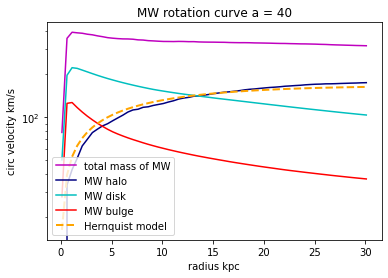

In [481]:
# plotting MW rotation curves
plt.plot(r, total_velocity_MW, label='total mass of MW', c='m')
plt.plot(r, velocity_MW_halo, label='MW halo', c='navy')
plt.plot(r, velocity_MW_disk, label='MW disk', c='c')
plt.plot(r, velocity_MW_bulge, label='MW bulge', c='red')
plt.plot(r,hernquist_profile, '--',label='Hernquist model', c='orange', linewidth=2)
plt.yscale('log')
plt.ylabel('circ velocity km/s')
plt.xlabel('radius kpc')
plt.title("MW rotation curve a = %s" % a)
plt.legend()

# M31 mass profile

In [482]:
# initializing M31 classs
M31 = MassProfile("M31", 0)
r = np.arange(0.25, 30.5, 0.5);print(r)

# calculating enclosed mass for each galaxy component for each radius
enclosed_mass_M31_halo = M31.MassEnclosed(1,r)
enclosed_mass_M31_disk = M31.MassEnclosed(2,r)
enclosed_mass_M31_bulge = M31.MassEnclosed(3,r)

#calculating the total mass enclosed at each radius
total_mass_M31 = M31.MassEnclosedTotal(r)


[ 0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75
  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75 11.25 11.75
 12.25 12.75 13.25 13.75 14.25 14.75 15.25 15.75 16.25 16.75 17.25 17.75
 18.25 18.75 19.25 19.75 20.25 20.75 21.25 21.75 22.25 22.75 23.25 23.75
 24.25 24.75 25.25 25.75 26.25 26.75 27.25 27.75 28.25 28.75 29.25 29.75
 30.25]
[-377.03  611.41 -284.81] kpc
[-377.66  611.43 -284.64] kpc
[-377.23  610.98 -284.37] kpc
[-377.03  611.41 -284.81] kpc
[-377.66  611.43 -284.64] kpc
[-377.23  610.98 -284.37] kpc


In [483]:
a = 60 # estimated scale factor for M31
hernquist_profile_M31 = M31.HernquistMass(r, a, sum(M31.m_new*1e12)) # finding hernquist model halo mass enclosed


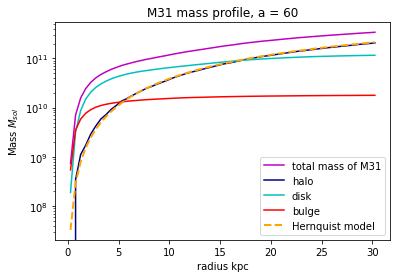

In [484]:
# plotting M31 mass profile
plt.semilogy(r, total_mass_M31, label='total mass of M31', c='m')
plt.semilogy(r, enclosed_mass_M31_halo, label='halo', c='navy')
plt.semilogy(r, enclosed_mass_M31_disk, label='disk', c='c')
plt.semilogy(r, enclosed_mass_M31_bulge, label='bulge', c='red')
plt.semilogy(r,hernquist_profile_M31, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('Mass $M_{sol}$')
plt.xlabel('radius kpc')
plt.title("M31 mass profile, a = %s" % a)
plt.legend()

# M31 velocity curve

In [485]:
# calculating the circular velocity at each radius for each galaxy component
velocity_M31_halo = M31.CircularVelocity(1, r, G)
velocity_M31_disk = M31.CircularVelocity(2, r, G)
velocity_M31_bulge = M31.CircularVelocity(3, r, G)
# calculating the circular velocity at each radius for total mass
total_velocity_M31 = M31.CircularVelocityTotal(r, G)

[-377.03  611.41 -284.81] kpc
[-377.66  611.43 -284.64] kpc
[-377.23  610.98 -284.37] kpc
[-377.03  611.41 -284.81] kpc
[-377.66  611.43 -284.64] kpc
[-377.23  610.98 -284.37] kpc


In [486]:
a = 60 #scale factor for M31
# finding the hernquist model of circular velocity
hernquist_profile_M31 = M31.HernquistVcirc(r,a, sum(M31.m_new*1e12), G)


[ 23.75  40.8   52.25  61.32  68.97  75.65  81.58  86.95  91.84  96.35
 100.51 104.39 108.01 111.41 114.61 117.62 120.46 123.16 125.71 128.14
 130.45 132.65 134.75 136.75 138.66 140.49 142.24 143.92 145.53 147.07
 148.54 149.96 151.33 152.64 153.89 155.11 156.27 157.39 158.47 159.51
 160.51 161.47 162.4  163.29 164.16 164.99 165.79 166.56 167.31 168.03
 168.72 169.39 170.03 170.66 171.26 171.84 172.39 172.93 173.45 173.95
 174.44] km / s


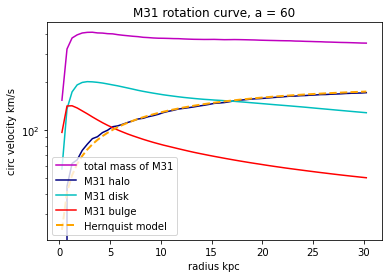

In [487]:
# plotting M31 rotation curves
plt.plot(r, total_velocity_M31, label='total mass of M31', c='m')
plt.plot(r, velocity_M31_halo, label='M31 halo', c='navy')
plt.plot(r, velocity_M31_disk, label='M31 disk', c='c')
plt.plot(r, velocity_M31_bulge, label='M31 bulge', c='red')
plt.plot(r,hernquist_profile_M31, '--',label='Hernquist model', c='orange', linewidth=2)
plt.yscale('log')
plt.ylabel('circ velocity km/s')
plt.xlabel('radius kpc')
plt.title("M31 rotation curve, a = %s" % a)
plt.legend()

# M33 mass profile

In [488]:
# initializing M33 classs
M33 = MassProfile("M33", 0)
r = np.arange(0.25, 30.5, 0.5);print(r)

# calculating enclosed mass for each galaxy component for each radius
enclosed_mass_M33_halo = M33.MassEnclosed(1,r)
enclosed_mass_M33_disk = M33.MassEnclosed(2,r)
#calculating the total mass enclosed at each radius
total_mass_M33 = M33.MassEnclosedTotal(r)


[ 0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75
  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75 11.25 11.75
 12.25 12.75 13.25 13.75 14.25 14.75 15.25 15.75 16.25 16.75 17.25 17.75
 18.25 18.75 19.25 19.75 20.25 20.75 21.25 21.75 22.25 22.75 23.25 23.75
 24.25 24.75 25.25 25.75 26.25 26.75 27.25 27.75 28.25 28.75 29.25 29.75
 30.25]
[-478.76  490.41 -411.68] kpc
[-476.22  491.44 -412.4 ] kpc
[-478.76  490.41 -411.68] kpc
[-476.22  491.44 -412.4 ] kpc


In [489]:
a = 80 # estimated scale factor
hernquist_profile_M33 = M33.HernquistMass(r, a, sum(M33.m_new*1e12)) # finding hernquist model halo mass enclosed


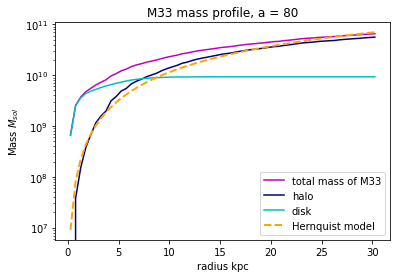

In [490]:
# plotting M33 mass profile
plt.semilogy(r, total_mass_M33, label='total mass of M33', c='m')
plt.semilogy(r, enclosed_mass_M33_halo, label='halo', c='navy')
plt.semilogy(r, enclosed_mass_M33_disk, label='disk', c='c')
plt.semilogy(r,hernquist_profile_M33, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('Mass $M_{sol}$')
plt.xlabel('radius kpc')
plt.title("M33 mass profile, a = %s" % a)
plt.legend()

# M33 velocity profile

In [491]:
# calculating the circular velocity at each radius for each galaxy component
velocity_M33_halo = M33.CircularVelocity(1, r, G)
velocity_M33_disk = M33.CircularVelocity(2, r, G)
# calculating the circular velocity at each radius for total mass
total_velocity_M33 = M33.CircularVelocityTotal(r, G)

[-478.76  490.41 -411.68] kpc
[-476.22  491.44 -412.4 ] kpc
[-478.76  490.41 -411.68] kpc
[-476.22  491.44 -412.4 ] kpc


In [492]:
a = 80 # scaled factor
# finding the hernquist model of circular velocity
hernquist_profile_M33 = M33.HernquistVcirc(r,a, sum(M33.m_new*1e12), G)

[12.46 21.45 27.52 32.36 36.47 40.08 43.31 46.24 48.94 51.43 53.75 55.93
 57.97 59.9  61.72 63.45 65.09 66.66 68.15 69.58 70.95 72.26 73.51 74.72
 75.88 77.   78.07 79.1  80.1  81.07 82.   82.89 83.76 84.6  85.41 86.2
 86.96 87.7  88.41 89.1  89.77 90.42 91.06 91.67 92.26 92.84 93.4  93.94
 94.47 94.99 95.48 95.97 96.44 96.9  97.34 97.78 98.2  98.61 99.01 99.39
 99.77] km / s


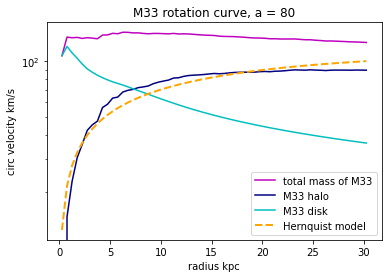

In [493]:
# plotting M33 rotation curve
plt.plot(r, total_velocity_M33, label='total mass of M33', c='m')
plt.plot(r, velocity_M33_halo, label='M33 halo', c='navy')
plt.plot(r, velocity_M33_disk, label='M33 disk', c='c')
plt.plot(r,hernquist_profile_M33, '--',label='Hernquist model', c='orange', linewidth=2)
plt.yscale('log')
plt.ylabel('circ velocity km/s')
plt.xlabel('radius kpc')
plt.title("M33 rotation curve, a = %s" % a)
plt.legend()